# Final Capstone - Recommendation Models

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
import statsmodels.api as sm
import seaborn as sns
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import normalize
%matplotlib inline
from sklearn import neighbors
from sklearn.model_selection import cross_val_score
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
import re
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from pylab import *
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.externals import joblib
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.datasets import make_multilabel_classification
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

C:\Users\kylem\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
C:\Users\kylem\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
#upload the us_brewery_reviews dataset from the previous EDA notebook
beer = pd.read_csv(r'F:\Datasets\us_brewery_reviews.csv')

In [4]:
#preview the dataset
pd.set_option('display.max_columns', None)
beer.head()

,Unnamed: 0,beer_id,username,date,text,look,smell,taste,feel,overall,score,beer_name,brewery_id,state,country,style,availability,abv,beer_notes,retired,brewery_name,city,brewery_notes,types,without_stopwords,lemmatized_text
0,0,115317,KrajDoesBeer,2015-04-17,10.24 batch. citra all in the nose.. some dank...,5.00,5.00,5.0,4.75,5.0,4.98,Dinner,20681,ME,US,New England IPA,Rotating,8.2,"Our first Double IPA – dry, refreshing and hop...",f,Maine Beer Company,Freeport,No notes at this time.,"Brewery, Bar, Beer-to-go",10.24 batch. citra nose.. dankness well.. look...,batch citra nose dankness well look classic ha...
1,2,115317,Mmart802,2016-04-22,This beer was a real treat. Lots of sweet hop ...,5.00,4.75,5.0,4.75,5.0,4.92,Dinner,20681,ME,US,New England IPA,Rotating,8.2,"Our first Double IPA – dry, refreshing and hop...",f,Maine Beer Company,Freeport,No notes at this time.,"Brewery, Bar, Beer-to-go",This beer real treat. Lots sweet hop citrus no...,real treat lot sweet hop citrus note crisp dip...
2,7,115317,Edmuzz,2016-04-15,This is a wonderful offering from MBC. While I...,5.00,4.75,5.0,4.75,5.0,4.92,Dinner,20681,ME,US,New England IPA,Rotating,8.2,"Our first Double IPA – dry, refreshing and hop...",f,Maine Beer Company,Freeport,No notes at this time.,"Brewery, Bar, Beer-to-go",This wonderful offering MBC. While I'm huge fa...,wonderful offering mbc huge fan hype real hard...
3,8,115317,Lelandt,2016-04-07,Amazing. That's the only word for it,4.75,5.00,5.0,5.00,5.0,4.99,Dinner,20681,ME,US,New England IPA,Rotating,8.2,"Our first Double IPA – dry, refreshing and hop...",f,Maine Beer Company,Freeport,No notes at this time.,"Brewery, Bar, Beer-to-go",Amazing. That's word,amazing word
4,16,115317,PittstopBrewing,2016-04-14,Most likely the best beer I have ever had. Sme...,5.00,5.00,5.0,5.00,5.0,5.00,Dinner,20681,ME,US,New England IPA,Rotating,8.2,"Our first Double IPA – dry, refreshing and hop...",f,Maine Beer Company,Freeport,No notes at this time.,"Brewery, Bar, Beer-to-go","Most likely best beer I ever had. Smell, look,...",likely best ever smell look taste perfect


In [5]:
#no need for the "unnamed" column
beer = beer.drop(['Unnamed: 0'], axis=1)

In [6]:
#count the beer_id's, choose the most popular beers to be in the dataframe
beer['review_count'] = beer['beer_id'].groupby(beer['beer_id']).transform('count')

In [7]:
#sort the beers by number of reviews
pd.set_option('display.max_columns', None)
beer.sort_values(by=['review_count'], ascending=False)

,beer_id,username,date,text,look,smell,taste,feel,overall,score,beer_name,brewery_id,state,country,style,availability,abv,beer_notes,retired,brewery_name,city,brewery_notes,types,without_stopwords,lemmatized_text,review_count
44977,11757,wuthrichj15,2015-12-29,Just wow...what an absolutely fantastic beer. ...,5.00,5.00,5.00,5.00,5.00,5.00,Breakfast Stout,1199,MI,US,American Imperial Stout,Rotating,8.30,Availability: Sep - Dec,f,Founders Brewing Company,Grand Rapids,Mahou San Miguel has a 30% ownership stake sin...,"Brewery, Bar, Eatery, Beer-to-go",Just wow...what absolutely fantastic beer. Cho...,wow absolutely fantastic chocolate coffee flav...,4167
48010,11757,spoony,2014-12-28,"From a 355 ml bottle (bottled November 24, 201...",4.25,4.25,4.50,3.75,4.25,4.30,Breakfast Stout,1199,MI,US,American Imperial Stout,Rotating,8.30,Availability: Sep - Dec,f,Founders Brewing Company,Grand Rapids,Mahou San Miguel has a 30% ownership stake sin...,"Brewery, Bar, Eatery, Beer-to-go","From 355 ml bottle (bottled November 24, 2014)...",ml bottle bottled november wine glass thin bro...,4167
48012,11757,hophugger,2014-11-12,"Black, that is the color, 'nuff said. Head is ...",4.50,4.25,4.50,4.25,4.25,4.37,Breakfast Stout,1199,MI,US,American Imperial Stout,Rotating,8.30,Availability: Sep - Dec,f,Founders Brewing Company,Grand Rapids,Mahou San Miguel has a 30% ownership stake sin...,"Brewery, Bar, Eatery, Beer-to-go","Black, color, 'nuff said. Head white/coffee co...",black color nuff said head white coffee colore...,4167
48013,11757,Gregaroo,2014-12-03,10-16-16 - On tap at Moriarty's in Philly. Ser...,4.00,4.00,4.25,4.25,4.25,4.18,Breakfast Stout,1199,MI,US,American Imperial Stout,Rotating,8.30,Availability: Sep - Dec,f,Founders Brewing Company,Grand Rapids,Mahou San Miguel has a 30% ownership stake sin...,"Brewery, Bar, Eatery, Beer-to-go",10-16-16 - On tap Moriarty's Philly. Served da...,tap moriarty philly served dark almost black c...,4167
48014,11757,infinitebruner,2014-11-28,"November 22, 2014 12 oz bottle, snifter A – In...",4.00,4.50,4.25,3.75,4.25,4.25,Breakfast Stout,1199,MI,US,American Imperial Stout,Rotating,8.30,Availability: Sep - Dec,f,Founders Brewing Company,Grand Rapids,Mahou San Miguel has a 30% ownership stake sin...,"Brewery, Bar, Eatery, Beer-to-go","November 22, 2014 12 oz bottle, snifter A – In...",november bottle snifter ink black light brown ...,4167
48015,11757,RonaldTheriot,2014-12-11,"Founders Breakfast Stout has a thin, beige hea...",4.00,4.25,4.25,4.00,4.25,4.21,Breakfast Stout,1199,MI,US,American Imperial Stout,Rotating,8.30,Availability: Sep - Dec,f,Founders Brewing Company,Grand Rapids,Mahou San Miguel has a 30% ownership stake sin...,"Brewery, Bar, Eatery, Beer-to-go","Founders Breakfast Stout thin, beige head, dar...",founder breakfast stout thin beige head dark b...,4167
48016,11757,ClavisAurea,2014-12-12,Fresh 12oz bottle served in a snifter glass. B...,4.25,4.25,4.25,4.25,4.25,4.25,Breakfast Stout,1199,MI,US,American Imperial Stout,Rotating,8.30,Availability: Sep - Dec,f,Founders Brewing Company,Grand Rapids,Mahou San Miguel has a 30% ownership stake sin...,"Brewery, Bar, Eatery, Beer-to-go",Fresh 12oz bottle served snifter glass. Bottle...,fresh bottle served snifter glass bottle dated...,4167
48017,11757,antonyliu,2018-09-29,12oz bottle poured into snifter glass --------...,4.50,4.00,3.75,4.25,4.25,4.01,Breakfast Stout,1199,MI,US,American Imperial Stout,Rotating,8.30,Availability: Sep - Dec,f,Founders Brewing Company,Grand Rapids,Mahou San Miguel has a 30% ownership stake sin...,"Brewery, Bar, Eatery, Beer-to-go",12oz bottle poured snifter glass ---------- Lo...,bottle poured snifter glass look like pour cof...,4167
48018,11757,dutesanch,2015-01-19,"Very tasty, heavy coffee flavor with mild dark...",4.00,4.50,4.25,4.00,4.25,4.27,Breakfast Stout,1199,MI,US,American Imperial Stout,Rotating,8.30,Availability: Sep - Dec,f,Founders Brewing Company,Grand Rapids,Mahou San Miguel has a 30% ownership stake sin...

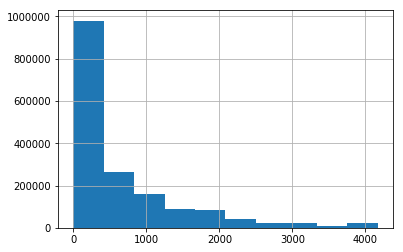

In [8]:
#histogram plot of beer reviews per beer
beer['review_count'].hist()

The above histogram is telling us that most beers have under 1000 reviews and in the rare case have 4000+ reviews. 

In [9]:
#how many unique beers will there be in the dataset when we cut off the threshold at 200 reviews?
beer_200 = beer[beer.review_count >= 200]

In [10]:
#get beer_200 info and find how many unique beers there are
beer_200['beer_id'].nunique()

1630

If a beer hasn't been reviewed at least 200 times, it will be dropped. This results in 1600+ unique beers made in the USA.

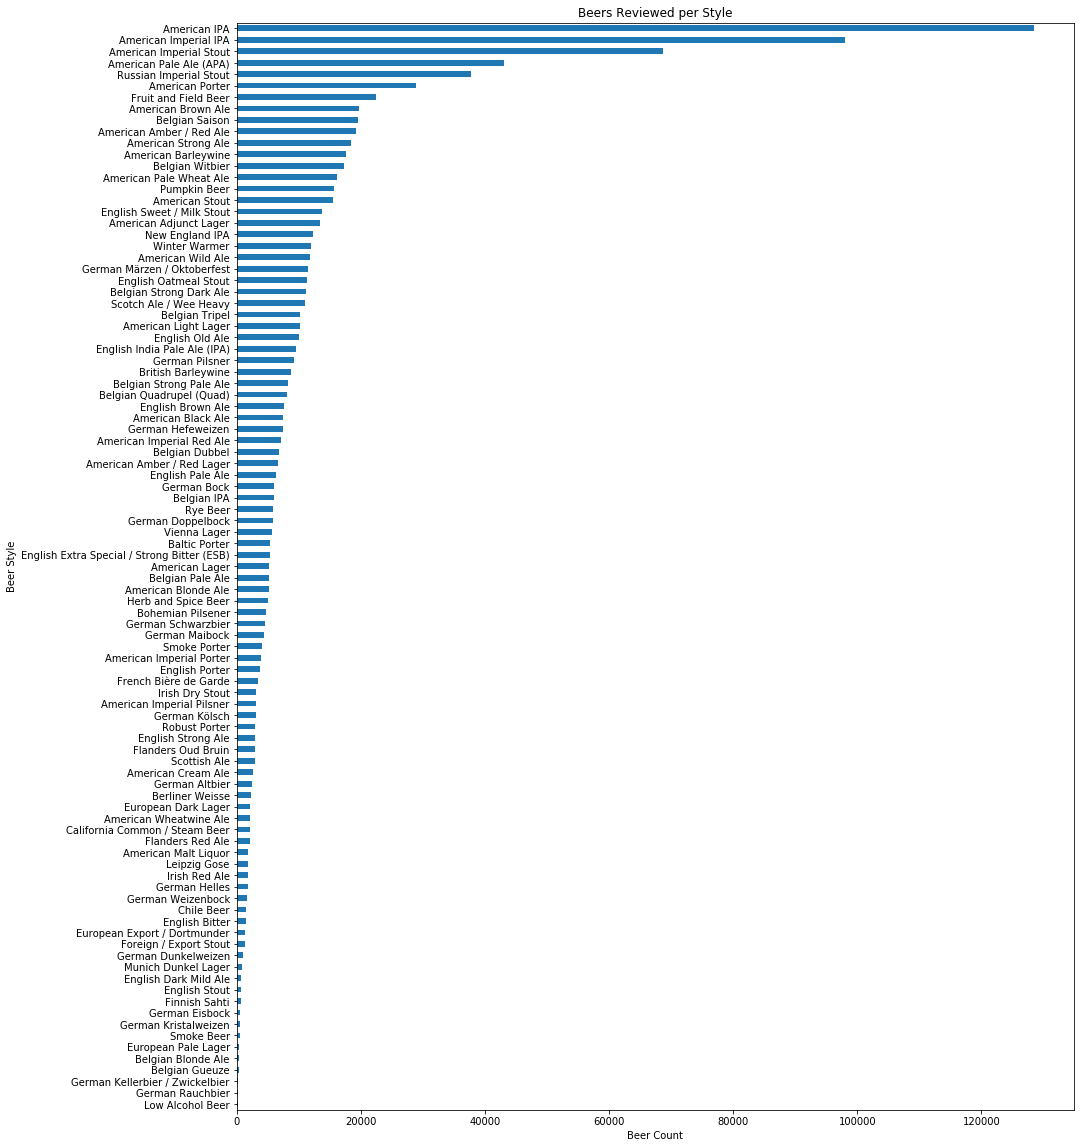

In [11]:
#visualize the amount of beers reviewed per style represented in the dataset

plt.figure(figsize=(15,20))
overall = beer_200.groupby('style')['beer_id'].count().sort_values(ascending=True).plot(kind='barh', title='Beers Reviewed per Style')
overall.set_xlabel('Beer Count')
overall.set_ylabel('Beer Style')
plt.show()

As we can see from the graph, the American IPA dominates the beers reviewed in the USA. This is not surprising as it is the most popular craft beer style. Brewers actually have a saying, "IPA's pay the bills." And it's true, consumers demand a high quality IPA because they're so well liked among the general population. Brewers, however, typically don't like brewing these styles as they can be a pain to brew with all the hop additions needed to achieve the proper flavor. 

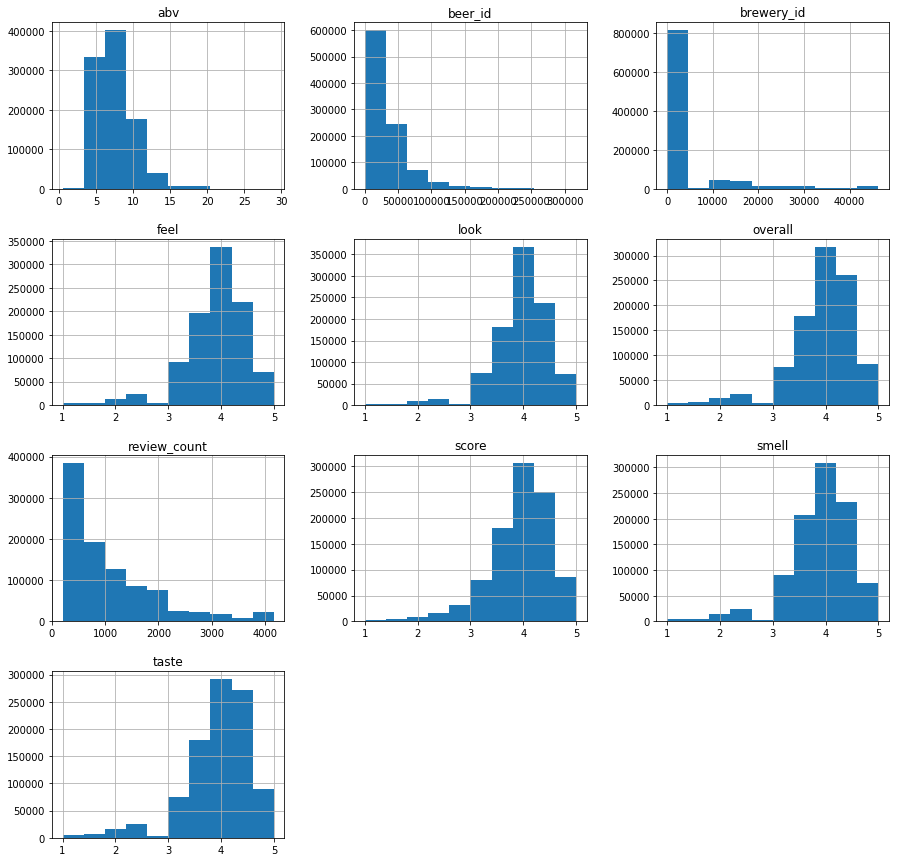

In [12]:
beer_200.hist(figsize=(15,15))
plt.show()

As we can see, as before with all countries and reviews, reviewers tend to leave reviews when they feel the beer is good. Most beers land in the 4 range out of a possible score of 5. 

## Content Recommender

Now that we have done some data analysis, we can start building the pieces of the recommender. First, we'll build the content recommender which will analyze the text reviews and recommend beers from the reviews. 

In [13]:
#create new dataframe
beer_200_text = beer_200[['beer_id', 'beer_name', 'brewery_name', 'lemmatized_text']]

In [14]:
#drop null values
beer_200_text = beer_200_text.dropna(axis=0, subset=['lemmatized_text'])

In [15]:
#group by beer
grouped_text = beer_200_text.groupby(['beer_id', 'brewery_name', 'beer_name'])['lemmatized_text'].agg(lambda col: ''.join(col))

#df
beer_200_text = pd.DataFrame(grouped_text)
beer_200_text = beer_200_text.reset_index()
beer_200_text.head()

,beer_id,brewery_name,beer_name,lemmatized_text
0,5,Abita Brewing Co.,Amber,becoming favorite mine pours dark golden color...
1,6,Abita Brewing Co.,Turbodog,fan dark flavorful ale met mark well started c...
2,7,Abita Brewing Co.,Purple Haze,purple virtually head second finger head dissi...
3,10,Allagash Brewing Company,Dubbel Ale,brown ml bottle corked caged batch bottled acc...
4,17,Widmer Brothers Brewing Company,Widmer Hefeweizen,american style hefe taste delicious every time...


In [16]:
beer_200_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1630 entries, 0 to 1629
Data columns (total 4 columns):
beer_id            1630 non-null int64
brewery_name       1630 non-null object
beer_name          1630 non-null object
lemmatized_text    1630 non-null object
dtypes: int64(1), object(3)
memory usage: 51.0+ KB


In [19]:
beer_200_text = pd.read_csv(r'F:\Datasets\beer_200_text.csv')

In [17]:
#using lemmatized_text, create the corpus
corpus = beer_200_text['lemmatized_text']
corpus

0       becoming favorite mine pours dark golden color...
1       fan dark flavorful ale met mark well started c...
2       purple virtually head second finger head dissi...
3       brown ml bottle corked caged batch bottled acc...
4       american style hefe taste delicious every time...
5       well balanced pale ale market made go food pai...
6       pours nearly pitch black color dark chocolatey...
7       nice sized head really beautiful lacing dark q...
8       pours hazy brown orange medium thick white hea...
9       tasted appearance pale hazy gold thin head qui...
10      great blask smoothdark brown almost black body...
11      appearance amber color clear lot fine bubble r...
12      bad representation budweiser always found kill...
13      good malt liquor cheaper areaokay know alot pe...
14      nothing ordinary usual blonde ale seems pushed...
15      ginger vanilla allspice pumpkin smell taste pr...
16      note like strong coffee like porter enjoy idea...
17      dark p

## Bag of Words

In [18]:
bag_of_words_model = CountVectorizer(max_features=100)
bag_of_words_model.fit_transform(corpus)

<1630x100 sparse matrix of type '<class 'numpy.int64'>'
	with 160012 stored elements in Compressed Sparse Row format>

In [19]:
bag_of_word_df = pd.DataFrame(bag_of_words_model.fit_transform(corpus).todense())
bag_of_word_df.columns = sorted(bag_of_words_model.vocabulary_)
bag_of_word_df.head()

,alcohol,ale,almost,amber,aroma,balance,balanced,big,bit,bitter,bitterness,black,bodied,body,bottle,brew,brown,caramel,carbonation,chocolate,citrus,clear,coffee,color,creamy,dark,decent,definitely,drink,drinkability,drinkable,dry,feel,finger,finish,first,flavor,floral,fruit,full,glass,go,golden,good,grapefruit,great,head,hint,hop,hoppy,ipa,lacing,leaf,light,like,little,lot,make,malt,malty,medium,mild,mouth,mouthfeel,much,nice,nose,note,orange,overall,pine,pint,poured,pours,pretty,quickly,quite,really,roasted,slight,slightly,smell,smooth,spice,still,stout,strong,style,sweet,sweetness,tan,taste,thick,thin,time,touch,vanilla,way,well,white
0,20,46,61,532,272,39,46,30,199,40,96,2,92,163,126,115,67,405,224,9,36,148,8,282,50,56,97,22,92,53,77,67,74,90,194,58,351,25,47,30,168,87,38,326,3,90,509,111,343,27,4,178,49,417,206,251,62,53,542,189,186,106,46,165,158,314,94,125,85,131,9,88,68,93,132,82,61,117,58,120,135,256,129,33,62,3,30,82,294,100,31,445,36,143,43,72,5,38,151,197
1,74,490,204,86,455,105,96,62,477,224,221,152,162,317,241,234,1467,435,401,875,15,85,431,329,187,874,186,95,178,108,170,150,143,198,382,129,682,19,135,102,390,122,2,639,1,171,955,343,570,50,5,337,91,652,508,413,140,107,1034,285,398,152,94,315,241,652,212,268,15,233,3,182,142,181,236,120,170,241,456,198,204,567,254,29,115,68,115,157,590,191,342,834,170,220,97,109,34,103,295,109
2,29,43,126,119,338,50,47,52,279,32,63,3,93,200,201,172,37,12,330,1,50,34,0,397,39,38,137,81,191,99,96,87,129,116,248,89,604,18,501,25,262,113,167,384,24,103,655,179,180,13,7,219,45,694,627,346,127,97,295,48,148,83,65,246,276,272,146,113,189,176,0,116,115,144,187,131,137,222,0,172,156,571,110,19,83,3,96,52,369,97,9,828,39,202,94,55,2,79,191,292
3,266,116,112,187,413,75,73,87,372,110,107,24,133,237,271,171,598,270,372,191,39,41,103,301,159,636,94,61,109,123,108,222,125,140,379,88,603,32,480,104,271,71,10,473,4,147,780,254,252,19,0,276,112,411,370,352,121,103,696,222,342,119,90,279,187,509,191,204,71,161,4,20,167,177,142,97,144,191,117,142,187,410,201,255,111,7,96,244,431,193,155,672,119,169,59,82,27,75,291,203
4,22,115,133,47,342,38,35,59,307,105,94,3,99,205,197,116,26,21,299,1,450,17,0,317,85,34,191,58,161,96,109,115,104,103,246,83,497,32,93,47,302,119,185,448,22,142,679,188,348,41,12,243,59,572,470,366,103,76,251,53,189,151,59,270,304,320,144,182,424,185,4,88,124,121,189,92,92,200,3,141,117,458,178,155,80,3,71,234,172,69,12,684,57,162,92,74,7,90,202,300


In [20]:
list(bag_of_word_df.columns.values)

['alcohol',
 'ale',
 'almost',
 'amber',
 'aroma',
 'balance',
 'balanced',
 'big',
 'bit',
 'bitter',
 'bitterness',
 'black',
 'bodied',
 'body',
 'bottle',
 'brew',
 'brown',
 'caramel',
 'carbonation',
 'chocolate',
 'citrus',
 'clear',
 'coffee',
 'color',
 'creamy',
 'dark',
 'decent',
 'definitely',
 'drink',
 'drinkability',
 'drinkable',
 'dry',
 'feel',
 'finger',
 'finish',
 'first',
 'flavor',
 'floral',
 'fruit',
 'full',
 'glass',
 'go',
 'golden',
 'good',
 'grapefruit',
 'great',
 'head',
 'hint',
 'hop',
 'hoppy',
 'ipa',
 'lacing',
 'leaf',
 'light',
 'like',
 'little',
 'lot',
 'make',
 'malt',
 'malty',
 'medium',
 'mild',
 'mouth',
 'mouthfeel',
 'much',
 'nice',
 'nose',
 'note',
 'orange',
 'overall',
 'pine',
 'pint',
 'poured',
 'pours',
 'pretty',
 'quickly',
 'quite',
 'really',
 'roasted',
 'slight',
 'slightly',
 'smell',
 'smooth',
 'spice',
 'still',
 'stout',
 'strong',
 'style',
 'sweet',
 'sweetness',
 'tan',
 'taste',
 'thick',
 'thin',
 'time',
 'tou

In [64]:
stop_words = stopwords.words('english')

In [67]:
tokenized_corpus = [word.lower() for sentence in corpus \
                    for word in word_tokenize(re.sub(r'([^\s\w]|_)+', ' ', sentence)) \
                    if word.lower() not in stop_words]

In [68]:
token_count_di = Counter(tokenized_corpus)
print('And the 100 most common words are...')
token_count_di.most_common(100)

And the 100 most common words are...


[('beer', 1142833),
 ('hop', 905447),
 ('head', 857259),
 ('malt', 752046),
 ('taste', 737256),
 ('flavor', 628865),
 ('nice', 605515),
 ('good', 558327),
 ('like', 537809),
 ('light', 510588),
 ('sweet', 483215),
 ('smell', 481698),
 ('one', 463716),
 ('aroma', 437327),
 ('carbonation', 419456),
 ('dark', 406510),
 ('bit', 404813),
 ('finish', 394313),
 ('well', 388364),
 ('glass', 362568),
 ('little', 355657),
 ('color', 334884),
 ('medium', 334793),
 ('lacing', 331255),
 ('bottle', 328984),
 ('chocolate', 321135),
 ('mouthfeel', 305388),
 ('white', 303654),
 ('citrus', 293534),
 ('note', 286817),
 ('really', 285518),
 ('body', 284962),
 ('caramel', 278980),
 ('brown', 277637),
 ('alcohol', 271518),
 ('great', 269775),
 ('coffee', 258958),
 ('bitterness', 255494),
 ('bitter', 252703),
 ('much', 249768),
 ('orange', 247967),
 ('pours', 247199),
 ('smooth', 236853),
 ('fruit', 235131),
 ('nose', 232709),
 ('would', 230024),
 ('overall', 226243),
 ('hint', 212753),
 ('sweetness', 210009

In [69]:
#the above generated list is a good place to start for adding more stop words

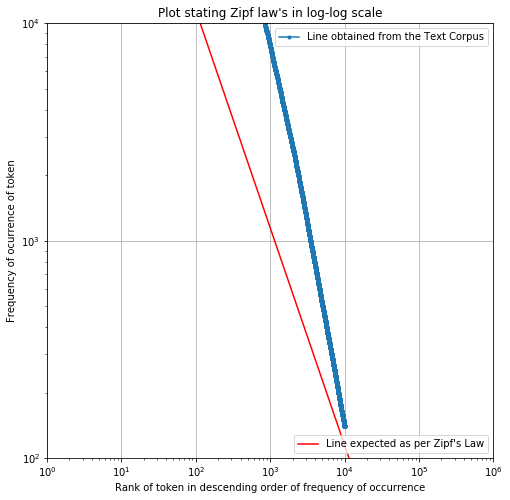

In [72]:
frequencies = [b for (a,b) in token_count_di.most_common(10000)]
tokens = [a for (a,b) in token_count_di.most_common(10000)]
ranks = range(1, len(frequencies)+1)
plt.figure(figsize=(8,8))
plt.ylim(10**2,10**4)
plt.xlim(1,10**6)
#Actual ranks and frequencies
obtained_line, = loglog(ranks, frequencies, marker=".", label="Text Corpus")
obtained_legend = plt.legend(handles=[obtained_line], loc=1)
ax = plt.gca().add_artist(obtained_legend)
#Expected ranks and frequencies as per Zipf's law
expected_line, = plt.plot([1,frequencies[0]],[frequencies[0],1],color='r',label="Line expected as per Zipf's Law")
plt.legend(handles=[expected_line], loc=4)
title("Plot stating Zipf law's in log-log scale")
xlabel("Rank of token in descending order of frequency of occurrence")
ylabel("Frequency of ocurrence of token")
grid(True)

## TF-IDF

In [21]:
#FEATURE EXTRACTION
#throw out any words used with 90% frequency or higher, throw out words that have been used less than 5 times
tfidf_model = TfidfVectorizer(max_features=100,
                             max_df=0.9,
                             min_df=5)

tfidf_matrix = tfidf_model.fit_transform(corpus).todense()

In [22]:
tfidf_matrix.shape

(1630, 100)

In [23]:
pd.set_option('display.max_columns', None)

In [24]:
tfidf_df = pd.DataFrame(tfidf_matrix)
tfidf_df.columns = sorted(tfidf_model.vocabulary_)
tfidf_df.head()

,adam,age,aged,apricot,banana,barleywine,barrel,beige,belgian,biscuity,bomber,booze,boozy,bourbon,burn,cherry,chocolate,cinnamon,citrusy,cloudy,clove,coast,cocoa,coffee,copper,coriander,corn,crystal,dipa,double,espresso,fig,funk,gold,grape,grapefruit,grass,haze,hazy,heat,hoppiness,ipa,ipas,juice,juicy,lager,lemon,licorice,mango,maple,milk,mocha,molasses,nut,nutmeg,nutty,oak,oil,opaque,peach,pear,peel,pilsner,pine,pineapple,piney,plum,porter,pumpkin,raisin,raspberry,reddish,resin,resinous,rind,roast,roasted,roasty,ruby,rye,sam,silky,smoke,stone,stout,straw,syrup,tangerine,tartness,toffee,tropical,warmth,west,wheat,winter,wood,woody,yeasty,yellow,zest
0,0.062938,0.004445,0.000000,0.009346,0.009081,0.000000,0.000000,0.034118,0.008974,0.123703,0.000000,0.000000,0.009382,0.025023,0.008825,0.018016,0.045181,0.023826,0.004289,0.034500,0.000000,0.000000,0.005973,0.043415,0.365357,0.000000,0.099249,0.089616,0.000000,0.000000,0.000000,0.005803,0.010628,0.069043,0.042490,0.013802,0.046138,0.072771,0.124599,0.013034,0.046166,0.016965,0.000000,0.034182,0.013196,0.764817,0.050863,0.017209,0.000000,0.005360,0.005158,0.000000,0.026175,0.126032,0.006090,0.230868,0.000000,0.004434,0.004231,0.009762,0.038170,0.000000,0.023917,0.038170,0.000000,0.004632,0.000000,0.016887,0.026579,0.025165,0.000000,0.070318,0.005194,0.000000,0.018822,0.016509,0.249199,0.082597,0.009585,0.005184,0.063371,0.016829,0.005280,0.000000,0.013630,0.019787,0.008582,0.000000,0.008969,0.180901,0.000000,0.004218,0.010053,0.062954,0.014064,0.017519,0.017080,0.055033,0.060938,0.013819
1,0.003861,0.002291,0.003406,0.000803,0.003900,0.002406,0.000000,0.028573,0.004625,0.005313,0.000000,0.003183,0.000000,0.006448,0.003032,0.020117,0.754586,0.011460,0.004420,0.003704,0.002705,0.002609,0.064639,0.401810,0.004329,0.000000,0.011366,0.013929,0.000000,0.000821,0.021666,0.016947,0.002739,0.000000,0.009489,0.000790,0.005764,0.008089,0.009595,0.002239,0.015140,0.003643,0.000000,0.004404,0.001511,0.015925,0.001456,0.006898,0.000000,0.003683,0.044300,0.030092,0.055757,0.107480,0.004185,0.124121,0.005956,0.004571,0.041426,0.000839,0.000000,0.001518,0.012326,0.002186,0.000000,0.003183,0.014994,0.094766,0.001141,0.031125,0.004280,0.060399,0.002677,0.000000,0.000000,0.047266,0.336567,0.076621,0.107025,0.008906,0.004666,0.007950,0.012697,0.003026,0.053074,0.001700,0.003686,0.000000,0.003081,0.275988,0.000000,0.005072,0.001727,0.013699,0.007248,0.009781,0.008802,0.007272,0.002243,0.002374
2,0.006051,0.000000,0.000000,0.004354,0.006111,0.000000,0.001135,0.000442,0.003252,0.002287,0.000000,0.000000,0.000000,0.001295,0.000914,0.006528,0.000520,0.000493,0.002664,0.069651,0.003804,0.000524,0.000000,0.000000,0.007391,0.000654,0.011988,0.002651,0.000701,0.000990,0.000000,0.000000,0.000550,0.022338,0.014077,0.011431,0.005211,0.071352,0.108983,0.002699,0.001738,0.003074,0.000000,0.015925,0.002733,0.041271,0.007021,0.000000,0.000614,0.000555,0.001602,0.000000,0.000542,0.001398,0.000000,0.000885,0.000000,0.000918,0.005694,0.015666,0.000494,0.000915,0.008914,0.000000,0.000000,0.000000,0.005847,0.000583,0.000000,0.000000,0.930605,0.015531,0.000000,0.000000,0.001949,0.000000,0.000000,0.000000,0.000496,0.001073,0.005155,0.000436,0.001640,0.000912,0.001411,0.019974,0.008441,0.002286,0.032964,0.000892,0.001060,0.000437,0.001041,0.323715,0.001941,0.000907,0.000442,0.012272,0.041009,0.002861
3,0.001634,0.022620,0.023418,0.011889,0.102318,0.002545,0.001992,0.046501,0.626253,0.019269,0.012218,0.020204,0.015344,0.002274,0.009622,0.132595,0.348491,0.050226,0.007793,0.147334,0.221286,0.003680,0.069464,0.203160,0.065632,0.061961,0.010020,0.006204,0.002462,0.064284,0.005730,0.181379,0.021246,0.006273,0.055595,0.006688,0.021342,0.028004,0.140542,0.001579,0.013728,0.000000,0.002060,0.009318,0.004796,0.001685,0.033891,0.020849,0.000000,0.023375,0.013122,0.012733,0.095134,0.094885,0.030989,0.090125,0.028804,0.001612,0.043054,0.010645,0.038151,0.022480,0.005216,0.006166,0.005775,0.005051,0.175411,0.014321,0.004830,0.292679,0.01

In [25]:
list(tfidf_df.columns.values)

['adam',
 'age',
 'aged',
 'apricot',
 'banana',
 'barleywine',
 'barrel',
 'beige',
 'belgian',
 'biscuity',
 'bomber',
 'booze',
 'boozy',
 'bourbon',
 'burn',
 'cherry',
 'chocolate',
 'cinnamon',
 'citrusy',
 'cloudy',
 'clove',
 'coast',
 'cocoa',
 'coffee',
 'copper',
 'coriander',
 'corn',
 'crystal',
 'dipa',
 'double',
 'espresso',
 'fig',
 'funk',
 'gold',
 'grape',
 'grapefruit',
 'grass',
 'haze',
 'hazy',
 'heat',
 'hoppiness',
 'ipa',
 'ipas',
 'juice',
 'juicy',
 'lager',
 'lemon',
 'licorice',
 'mango',
 'maple',
 'milk',
 'mocha',
 'molasses',
 'nut',
 'nutmeg',
 'nutty',
 'oak',
 'oil',
 'opaque',
 'peach',
 'pear',
 'peel',
 'pilsner',
 'pine',
 'pineapple',
 'piney',
 'plum',
 'porter',
 'pumpkin',
 'raisin',
 'raspberry',
 'reddish',
 'resin',
 'resinous',
 'rind',
 'roast',
 'roasted',
 'roasty',
 'ruby',
 'rye',
 'sam',
 'silky',
 'smoke',
 'stone',
 'stout',
 'straw',
 'syrup',
 'tangerine',
 'tartness',
 'toffee',
 'tropical',
 'warmth',
 'west',
 'wheat',
 'wi

Notice the descriptors present in the TF-IDF matrix, they are mostly descriptors such as "roasty", "tangerine", "tropical" and "biscuity". These are the words that I am after as they will differentiate beers the most. 

In [26]:
#calculate the cosine similarity of the matrix
from sklearn.metrics.pairwise import linear_kernel

cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [27]:
#Construct a reverse mapping of indices and beer names, and drop duplicate names, if any
indices = pd.Series(beer_200_text.index, index=beer_200_text['beer_name']).drop_duplicates()

## Content Recommender

In [28]:
# Function that takes in beer name as input and gives recommendations 
def content_recommender(title, cosine_sim=cosine_sim, df=beer_200_text, indices=indices):
    # Obtain the index of the beer that matches the name
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    beer_indices = [i[0] for i in sim_scores]

    
    return beer_200_text[['brewery_name', 'beer_name']].iloc[beer_indices]

In [29]:
content_recommender('Two Hearted Ale')

,brewery_name,beer_name
611,Smuttynose Brewing Company,"Smuttynose IPA ""Finest Kind"""
574,Boulder Beer / Wilderness Pub,Mojo IPA
1072,Boulevard Brewing Co.,Single-Wide IPA
374,Avery Brewing Company,Avery India Pale Ale (IPA)
253,SweetWater Brewing Company,Sweetwater IPA
461,Founders Brewing Company,Centennial IPA
737,Heavy Seas Beer,Loose Cannon Hop3 IPA
780,New England Brewing Co.,Sea Hag IPA
456,Dark Horse Brewing Company,Dark Horse Crooked Tree IPA
969,"Lakefront Brewery, Inc.",IPA


Ok, this is pretty neat. Notice that Founders Brewing Company's Centennial IPA is a top recommendation. The brewer who forumlated Two Hearted Ale (input) at Bell's also formulated Founders' Centennial IPA. Both beers contain one variety of hop - Centennial and have a very similar taste profile.

In [30]:
content_recommender('Breakfast Stout')

,brewery_name,beer_name
426,AleSmith Brewing Company,Speedway Stout
1409,Evil Twin Brewing,Imperial Biscotti Break
695,Terrapin Beer Company,W-n-B Coffee Oatmeal Imperial Stout
1468,Prairie Artisan Ales,Bomb!
1372,AleSmith Brewing Company,Speedway Stout - Vietnamese Coffee
1383,Flying Dog Brewery,Kujo Imperial Coffee Stout
1161,Tröegs Brewing Company,Java Head Stout
7,Redhook Ale Brewery,Redhook Double Black Stout
194,Dogfish Head Craft Brewery,Chicory Stout
1520,Perennial Artisan Ales,Sump Coffee Stout


Again, nice recommendations here. W-n-B Coffee Oatmeal Imperial Stout is definitely a beer I'd recommend if Breakfast Stout is a favorite. Speedway Stout is another that I would recommend especially if available. 

In [31]:
content_recommender('90 Minute IPA')

,brewery_name,beer_name
1022,BridgePort Brewing Co. / Brewpub,Hop Czar
1130,Dogfish Head Craft Brewery,Squall IPA
234,Lagunitas Brewing Company,Maximus
707,Breckenridge Brewery,471 Small Batch IPA
737,Heavy Seas Beer,Loose Cannon Hop3 IPA
958,Mendocino Brewing Company,Special Edition - Imperial IPA
568,Great Divide Brewing Company,Titan IPA
1114,Shipyard Brewing Company,Pugsley's Signature Series: XXXX IPA
984,Anderson Valley Brewing Company,Imperial IPA
169,Victory Brewing Company - Downingtown,HopDevil India Pale Ale


When searching a beer, the content recommender outputs mostly beers from the same style. This makes sense as it is built from the text reviews only, so it relies on the tf-idf matrix to make the recommendations. A hybrdized recommender could help diversify the outputs across styles by using the rating data within the dataset. 

## Collaborative Filter

In [32]:
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from surprise.model_selection import RandomizedSearchCV
from surprise import KNNBasic, KNNWithMeans, KNNWithZScore
from surprise import SVD, SVDpp, NMF 
from surprise import SlopeOne, CoClustering
from surprise import accuracy

In [33]:
#something is up with beer_200_collab - double check the code. I might just need to change the user id threshold (user_count)

In [34]:
reader = Reader()

In [35]:
beer_200.head()

,beer_id,username,date,text,look,smell,taste,feel,overall,score,beer_name,brewery_id,state,country,style,availability,abv,beer_notes,retired,brewery_name,city,brewery_notes,types,without_stopwords,lemmatized_text,review_count
0,115317,KrajDoesBeer,2015-04-17,10.24 batch. citra all in the nose.. some dank...,5.00,5.00,5.0,4.75,5.0,4.98,Dinner,20681,ME,US,New England IPA,Rotating,8.2,"Our first Double IPA – dry, refreshing and hop...",f,Maine Beer Company,Freeport,No notes at this time.,"Brewery, Bar, Beer-to-go",10.24 batch. citra nose.. dankness well.. look...,batch citra nose dankness well look classic ha...,361
1,115317,Mmart802,2016-04-22,This beer was a real treat. Lots of sweet hop ...,5.00,4.75,5.0,4.75,5.0,4.92,Dinner,20681,ME,US,New England IPA,Rotating,8.2,"Our first Double IPA – dry, refreshing and hop...",f,Maine Beer Company,Freeport,No notes at this time.,"Brewery, Bar, Beer-to-go",This beer real treat. Lots sweet hop citrus no...,real treat lot sweet hop citrus note crisp dip...,361
2,115317,Edmuzz,2016-04-15,This is a wonderful offering from MBC. While I...,5.00,4.75,5.0,4.75,5.0,4.92,Dinner,20681,ME,US,New England IPA,Rotating,8.2,"Our first Double IPA – dry, refreshing and hop...",f,Maine Beer Company,Freeport,No notes at this time.,"Brewery, Bar, Beer-to-go",This wonderful offering MBC. While I'm huge fa...,wonderful offering mbc huge fan hype real hard...,361
3,115317,Lelandt,2016-04-07,Amazing. That's the only word for it,4.75,5.00,5.0,5.00,5.0,4.99,Dinner,20681,ME,US,New England IPA,Rotating,8.2,"Our first Double IPA – dry, refreshing and hop...",f,Maine Beer Company,Freeport,No notes at this time.,"Brewery, Bar, Beer-to-go",Amazing. That's word,amazing word,361
4,115317,PittstopBrewing,2016-04-14,Most likely the best beer I have ever had. Sme...,5.00,5.00,5.0,5.00,5.0,5.00,Dinner,20681,ME,US,New England IPA,Rotating,8.2,"Our first Double IPA – dry, refreshing and hop...",f,Maine Beer Company,Freeport,No notes at this time.,"Brewery, Bar, Beer-to-go","Most likely best beer I ever had. Smell, look,...",likely best ever smell look taste perfect,361


In [36]:
beer_200_collab = beer_200[['beer_id', 'overall', 'brewery_name', 'username', 'beer_name']]

In [37]:
beer_200_collab.username = pd.Categorical(beer_200_collab.username)

In [38]:
beer_200_collab['user_id'] = beer_200_collab.username.cat.codes

In [219]:
beer_200_collab.to_csv(r'F:\Datasets\beer_200_collab')

KeyboardInterrupt: 

In [41]:
beer_200_collab = pd.read_csv(r'F:\Datasets\beer_200_collab')
beer_200_collab.head()

,Unnamed: 0,beer_id,overall,brewery_name,username,beer_name,user_id
0,0,115317,5.0,Maine Beer Company,KrajDoesBeer,Dinner,15606
1,1,115317,5.0,Maine Beer Company,Mmart802,Dinner,18242
2,2,115317,5.0,Maine Beer Company,Edmuzz,Dinner,8801
3,3,115317,5.0,Maine Beer Company,Lelandt,Dinner,16067
4,4,115317,5.0,Maine Beer Company,PittstopBrewing,Dinner,20737


In [42]:
beer_200_collab.describe()

,Unnamed: 0,beer_id,overall,user_id
count,701004.000000,701004.000000,701004.000000,701004.000000
mean,446034.519944,30674.068893,3.987393,27803.847765
std,283000.239738,39217.794117,0.637329,15360.534513
min,0.000000,17.000000,1.000000,0.000000
25%,205462.750000,1881.000000,3.750000,14504.000000
50%,419340.500000,17112.000000,4.000000,29030.000000
75%,672612.250000,47360.000000,4.500000,41114.000000
max,986162.000000,317146.000000,5.000000,52998.000000


We can shrink down this dataset into something more manageable for model building. Especially since knn will be a top candidate.

In [39]:
#how many unique users left reviews?
beer_200_collab['user_id'].nunique()

53000

In [40]:
#count the reviews left by users
beer_200_collab['user_count'] = beer_200_collab['user_id'].groupby(beer_200_collab['user_id']).transform('count')

In [41]:
#filter out those users who have not left at least 250 reviews
beer_200_collab = beer_200_collab[beer_200_collab.user_count >= 250]
beer_200_collab.describe()

,beer_id,overall,user_id,user_count
count,354861.000000,354861.000000,354861.000000,354861.000000
mean,30671.163926,3.900183,27865.538986,512.737852
std,36680.407897,0.607655,15376.718691,219.890497
min,5.000000,1.000000,37.000000,250.000000
25%,2009.000000,3.500000,14175.000000,342.000000
50%,20781.000000,4.000000,29155.000000,461.000000
75%,46793.000000,4.250000,41380.000000,627.000000
max,317146.000000,5.000000,52962.000000,1289.000000


In [42]:
beer_200_collab['user_id'].nunique()

809

In [47]:
#load the data for Surprise
data = Dataset.load_from_df(beer_200_collab[['user_id', 'beer_id', 'overall']], reader)

In [87]:
trainset = data.build_full_trainset()
testset = trainset.build_testset()

In [14]:
# Use the KNN algorithm
knn = KNNBasic()

# Run 5-fold cross-validation and then print results
knn_res = cross_validate(knn, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.4943  0.4902  0.4885  0.4917  0.4916  0.4912  0.0019  
MAE (testset)     0.3567  0.3540  0.3534  0.3554  0.3549  0.3549  0.0011  
Fit time          1.66    1.20    1.13    1.17    1.13    1.26    0.20    
Test time         7.08    6.80    6.87    6.75    6.64    6.83    0.15    


In [15]:
# Use the KNN algorithm
knn_wm = KNNWithMeans()

# Run 5-fold cross-validation and then print results
knn_wm_res = cross_validate(knn_wm, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.4785  0.4819  0.4799  0.4871  0.4826  0.4820  0.0030  
MAE (testset)     0.3509  0.3523  0.3508  0.3559  0.3548  0.3530  0.0021  
Fit time          1.20    1.24    1.18    1.18    1.17    1.19    0.02    
Test time         7.36    7.37    6.95    7.16    6.92    7.15    0.19    


In [16]:
# Use the SVD algorithm
svd = SVD()

# Run 5-fold cross-validation and then print results
svd_res = cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.4776  0.4787  0.4756  0.4777  0.4823  0.4784  0.0022  
MAE (testset)     0.3480  0.3489  0.3488  0.3488  0.3531  0.3495  0.0018  
Fit time          7.89    8.51    8.75    10.71   10.10   9.19    1.05    
Test time         0.30    0.30    0.30    0.34    0.48    0.34    0.07    


In [17]:
# Use the SVDpp algorithm
svdpp = SVDpp()

# Run 5-fold cross-validation and then print results 
svdpp_res = cross_validate(svdpp, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)  

Evaluating RMSE, MAE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.4681  0.4691  0.4778  0.4758  0.4755  0.4732  0.0039  
MAE (testset)     0.3423  0.3434  0.3483  0.3466  0.3460  0.3453  0.0022  
Fit time          594.02  591.60  591.53  628.26  667.22  614.53  29.80   
Test time         10.48   10.58   11.22   12.49   12.36   11.42   0.86    


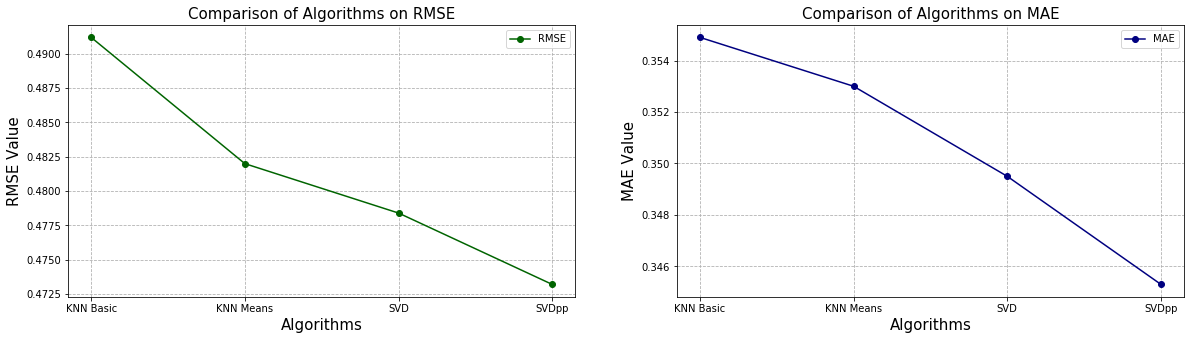

In [18]:
x_algo = ['KNN Basic', 'KNN Means', 'SVD', 'SVDpp']
all_algos_cv = [knn_res, knn_wm_res, svd_res, svdpp_res]

rmse_cv = [round(res['test_rmse'].mean(), 4) for res in all_algos_cv]
mae_cv = [round(res['test_mae'].mean(), 4) for res in all_algos_cv]

plt.figure(figsize=(20,5))

plt.subplot(1, 2, 1)
plt.title('Comparison of Algorithms on RMSE', loc='center', fontsize=15)
plt.plot(x_algo, rmse_cv, label='RMSE', color='darkgreen', marker='o')
plt.xlabel('Algorithms', fontsize=15)
plt.ylabel('RMSE Value', fontsize=15)
plt.legend()
plt.grid(ls='dashed')

plt.subplot(1, 2, 2)
plt.title('Comparison of Algorithms on MAE', loc='center', fontsize=15)
plt.plot(x_algo, mae_cv, label='MAE', color='navy', marker='o')
plt.xlabel('Algorithms', fontsize=15)
plt.ylabel('MAE Value', fontsize=15)
plt.legend()
plt.grid(ls='dashed')

plt.show()

Considering how long it took to run the SVDpp model, I think SVD is our best bet. Let's fine tune it and see how accurate it can become.

In [33]:
#tune the parameters with a GridSearch
svd_param_grid = {'n_epochs': [20, 25, 30],
                  'n_factors':[50,100,150],
                  'lr_all': [0.007, 0.009, 0.01],
                  'reg_all': [0.2, 0.4, 0.6]}

svd_gs = GridSearchCV(SVD, svd_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)
svd_gs.fit(data)

In [35]:
svd_gs.best_params

{'rmse': {'n_epochs': 30, 'n_factors': 150, 'lr_all': 0.007, 'reg_all': 0.2},
 'mae': {'n_epochs': 30, 'n_factors': 150, 'lr_all': 0.007, 'reg_all': 0.2}}

In [37]:
print(svd_gs.best_score['rmse'])
print(svd_gs.best_score['mae'])

0.4788962671716357
0.3511820928870556


In [39]:
n_epochs = [30, 60, 90]
n_factors = [150, 300, 450]
lr_all = [0.002, 0.005, 0.007]
reg_all = [0.05, 0.1, 0.2]


random_grid = {'n_epochs': n_epochs,
               'n_factors': n_factors,
               'lr_all': lr_all,
               'reg_all': reg_all}

In [154]:
svd_random = RandomizedSearchCV(SVD, random_grid, measures = ['rmse', 'mae'],
                                cv = 5, random_state=42)
svd_random.fit(data)

TypeError: 'SVD' object is not callable

In [45]:
svd_random.best_params

{'rmse': {'n_epochs': 90, 'n_factors': 450, 'lr_all': 0.005, 'reg_all': 0.05},
 'mae': {'n_epochs': 90, 'n_factors': 450, 'lr_all': 0.005, 'reg_all': 0.05}}

In [73]:
svd_random = svd_random.best_params

In [46]:
print(svd_random.best_score['rmse'])
print(svd_random.best_score['mae'])

0.4681694895375383
0.3434564813155974


In [53]:
# Use the SVD algorithm
svd_best = SVD(n_epochs=90, n_factors=450, lr_all=0.005, reg_all=0.05)
  
svd_best_res = cross_validate(svd_best, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.4695  0.4743  0.4679  0.4641  0.4678  0.4687  0.0033  
MAE (testset)     0.3416  0.3450  0.3410  0.3386  0.3406  0.3414  0.0021  
Fit time          195.65  177.84  180.06  193.39  199.53  189.29  8.70    
Test time         0.37    0.23    0.39    0.25    0.43    0.33    0.08    


In [47]:
import pickle

filename = 'svd_random.sav'
pickle.dump(svd_random, open(filename, 'wb'))

In [164]:
import pickle

filename = 'svdpp.sav'
pickle.dump(svdpp, open(filename, 'wb'))

In [57]:
svd_best.predict(46, 5121, 6)

Prediction(uid=46, iid=5121, r_ui=6, est=3.9365111631753034, details={'was_impossible': False})

## Hybrid Recommender

In [221]:
#beer id df to extract from
beer_ids = beer_200_collab[['beer_name', 'beer_id', 'user_id', 'brewery_name']]
beer_ids.head()

,beer_name,beer_id,user_id,brewery_name
0,Dinner,115317,15606,Maine Beer Company
1,Dinner,115317,18242,Maine Beer Company
2,Dinner,115317,8801,Maine Beer Company
3,Dinner,115317,16067,Maine Beer Company
4,Dinner,115317,20737,Maine Beer Company


In [222]:
#drop duplicates
beer_ids = beer_ids.drop_duplicates(subset=['beer_name', 'beer_id'], keep='first')

In [223]:
#reset index
beer_ids = beer_ids.reset_index()

In [224]:
#rename columns
beer_ids = beer_ids.rename(columns={'index': 'id'})
beer_ids.head()

,id,beer_name,beer_id,user_id,brewery_name
0,0,Dinner,115317,15606,Maine Beer Company
1,361,Lunch,68916,5115,Maine Beer Company
2,1303,A Tiny Beautiful Something,113339,44298,Maine Beer Company
3,1677,Peeper,51512,7339,Maine Beer Company
4,2339,King Titus,85822,16436,Maine Beer Company


In [225]:
beer_ids.to_csv(r'F:\Datasets\beer_ids.csv')

In [48]:
beer_ids = pd.read_csv(r'F:\Datasets\beer_ids.csv')

In [49]:
id_map = beer_ids
id_to_name = id_map.set_index('id')
name_to_id = id_map.set_index('beer_name')

In [50]:
user_id = beer_200_collab['user_id']

In [51]:
def hybrid(user_id, title):
    idx = indices[title]
    
    tnid = name_to_id.loc[title]['beer_id']
    beer_id = name_to_id.loc[title]['id']
    
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    beer_indices = [i[0] for i in sim_scores]
    
    beers = beer_ids.iloc[beer_indices][['beer_name', 'brewery_name', 'beer_id', 'id']]
    beers['est'] = beers['id'].apply(lambda x: svd_best.predict(user_id, id_to_name.loc[x]['beer_id']).est)
    beers = beers.sort_values('est', ascending=False)
    return beers.head(10)

In [1]:
hybrid(34092, 'Bud Light')

NameError: name 'hybrid' is not defined

In [59]:
hybrid(9657, 'Two Hearted Ale')

,beer_name,brewery_name,beer_id,id,est
657,The Event Horizon,Olde Hickory Brewery,64226,621352,4.412054
826,Vicinity,Trillium Brewing Company,145496,771488,4.395805
461,Sunday Morning Stout,Weyerbacher Brewing Co.,89345,428231,4.330975
456,Saison-Brett,Boulevard Brewing Co.,36333,424230,4.322379
653,IPA,AleSmith Brewing Company,3916,617326,4.320003
374,Brewhouse Coffee Stout,Central Waters Brewing Co.,35930,356243,4.280599
737,Hoponius Union,Jack's Abby Brewing,71820,691332,4.276804
449,Bourbon Barrel Quad Barrel-Aged Ale (BBQ),Boulevard Brewing Co.,43670,420123,4.172480
253,Baltic Porter,The Duck-Rabbit Craft Brewery,32180,238002,4.155490
969,668 Neighbor Of The Beast,New England Brewing Co.,58731,907232,4.005760


In [60]:
hybrid(10170, 'Two Hearted Ale')

,beer_name,brewery_name,beer_id,id,est
657,The Event Horizon,Olde Hickory Brewery,64226,621352,4.348099
826,Vicinity,Trillium Brewing Company,145496,771488,4.295432
456,Saison-Brett,Boulevard Brewing Co.,36333,424230,4.267272
653,IPA,AleSmith Brewing Company,3916,617326,4.262768
461,Sunday Morning Stout,Weyerbacher Brewing Co.,89345,428231,4.249732
737,Hoponius Union,Jack's Abby Brewing,71820,691332,4.242807
374,Brewhouse Coffee Stout,Central Waters Brewing Co.,35930,356243,4.232195
449,Bourbon Barrel Quad Barrel-Aged Ale (BBQ),Boulevard Brewing Co.,43670,420123,4.075476
253,Baltic Porter,The Duck-Rabbit Craft Brewery,32180,238002,4.033859
969,668 Neighbor Of The Beast,New England Brewing Co.,58731,907232,3.952548


Welp, I did it. I built a hybrid recommender that actually works and spits out some solid recommendations. Might be time to start cleaning up the notebook, leaving commentary where necessary. Also, edit the hybrid recommender to also say the brewery.

To finish this up, go back and tune the models to the best RMSE/MAE values we can get and visualize the scores. Use the best performing algorithm (most likely SVD), tune it, then apply it to the recommender. Then polish up the notebook, turn it in and start working on the presentation.

Questions for Don:

When shrinking the beer_200_collab data, how best to do it? Take a random sample? Or filter the number of reviewers by number of reviews left? 